In [1]:
import time
import re
from concurrent.futures import ThreadPoolExecutor
from typing import List, Tuple
import pandas as pd

from together import Together

from datasets import load_dataset
from rich import print as rprint

/Users/stevenkolawole/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/stevenkolawole/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
client = Together(api_key="e214758ef6f7bf0c1694b005c9523f760959be88c7ede4fa070914f107d46656")

def call_model_api(prompt: str, model: str, temperature: float = 0.6) -> Tuple[str, int]:
    chat_completion = client.chat.completions.create(
        messages=[
            {
                "role": "system",
                "content": "You are an AI assistant",
            },
            {
                "role": "user",
                "content": TEMPLATE.format(input_q=prompt)
            }
        ],
        model=model,
        max_tokens=1024,
        temperature=temperature,
    )
    completion = chat_completion.choices[0].message.content
    total_tokens = chat_completion.usage.total_tokens
    return completion, total_tokens


In [3]:
def calculate_cost(model: str, total_tokens: int) -> float:
    model_sizes = {
        'meta-llama/Llama-3-70b-chat-hf': 70,
        'meta-llama/Meta-Llama-3-70B-Instruct-Turbo': 70,
        'meta-llama/Meta-Llama-3-8B-Instruct-Turbo': 8,
        'meta-llama/Llama-3-8b-chat-hf': 8,
        'google/gemma-7b-it': 7,
        'mistralai/Mistral-7B-Instruct-v0.3': 7,
        'mistralai/Mistral-7B-Instruct-v0.1': 7,
        'mistralai/Mistral-8x7B-Instruct-v0.1': 56,
        'allenai/OLMo-7B': 7,
        'Qwen/Qwen1.5-7B-Chat': 7,
        'togethercomputer/alpaca-7b': 7,
        'togethercomputer/RedPajama-INCITE-7B-Chat': 7,
        'Undi95/Toppy-M-7B': 7
    }
    
    model_size = model_sizes.get(model, 7)  # Default to 7B if model not found
    
    if model_size <= 4:
        price_per_million = 0.10
    elif 4 < model_size <= 8:
        price_per_million = 0.20
    elif 8 < model_size <= 21:
        price_per_million = 0.30
    elif 21 < model_size <= 41:
        price_per_million = 0.80
    elif 41 < model_size <= 80:
        price_per_million = 0.90
    else:
        price_per_million = 1.80
    
    return (total_tokens / 1_000_000) * price_per_million

In [4]:
TEMPLATE = '''
Complete the text, start with 'Answer' and the last line starts with '#### = '. the value after '####' is the final value retrieved from the longer explanation of 'Answer'. ENSURE that you end your output with '####', followed by the final numerical value.

Question: Natalia sold clips to 48 of her friends in April, and then she sold half as many clips in May. How many clips did Natalia sell altogether in April and May?
Answer: Natalia sold 48/2 = <<48/2=24>>24 clips in May. Natalia sold 48+24 = <<48+24=72>>72 clips altogether in April and May. 
#### 72

Question: Weng earns $12 an hour for babysitting. Yesterday, she just did 50 minutes of babysitting. How much did she earn?	
Answer: Weng earns 12/60 = $<<12/60=0.2>>0.2 per minute. Working 50 minutes, she earned 0.2 x 50 = $<<0.2*50=10>>10. 
#### 10

Question: Betty is saving money for a new wallet which costs $100. Betty has only half of the money she needs. Her parents decided to give her $15 for that purpose, and her grandparents twice as much as her parents. How much more money does Betty need to buy the wallet?	
Answer: In the beginning, Betty has only 100 / 2 = $<<100/2=50>>50. Betty's grandparents gave her 15 * 2 = $<<15*2=30>>30. This means, Betty needs 100 - 50 - 30 - 15 = $<<100-50-30-15=5>>5 more. 
#### 5

Question: Julie is reading a 120-page book. Yesterday, she was able to read 12 pages and today, she read twice as many pages as yesterday. If she wants to read half of the remaining pages tomorrow, how many pages should she read?	
Answer: Maila read 12 x 2 = <<12*2=24>>24 pages today. So she was able to read a total of 12 + 24 = <<12+24=36>>36 pages since yesterday. There are 120 - 36 = <<120-36=84>>84 pages left to be read. Since she wants to read half of the remaining pages tomorrow, then she should read 84/2 = <<84/2=42>>42 pages. 
#### 42

Question: James writes a 3-page letter to 2 different friends twice a week. How many pages does he write a year?
Answer: He writes each friend 3*2=<<3*2=6>>6 pages a week So he writes 6*2=<<6*2=12>>12 pages every week That means he writes 12*52=<<12*52=624>>624 pages a year 
#### 624

Question: {input_q}

'''

In [6]:
def load_validation_split(dataset_name: str = "openai/gsm8k", n: int = 25) -> Tuple[List[str], List[str]]:
    val_dataset = load_dataset(dataset_name, "main")['test']
    questions = val_dataset['question'][:n]
    answers = val_dataset['answer'][:n]
    return questions, answers

def calculate_accuracy(responses: List[str], correct_answers: List[str]) -> float:
    label_pattern = r'#### (-?\d+)'
    formatted_labels = [re.search(label_pattern, s).group(1) for s in correct_answers]
    correct_count = sum(1 for response, correct in zip(responses, formatted_labels) if response == correct)
    return correct_count / len(correct_answers)

def extract_answer(raw_responses: List[str]) -> List[str]:
    pred_pattern = r'#### (-?\d+)'
    responses = []
    for r in raw_responses:
        try:
            responses.append(re.search(pred_pattern, r).group(1))
        except AttributeError:
            print("Answer not found; ", r)
            print("\n\n")
            responses.append("N/A")
    return responses

In [7]:
def run_experiment(method: str, dataset_name: str):
    questions, correct_answers = load_validation_split(dataset_name) # add 'n = -1' for full dataset sweep

    total_accuracy = 0
    total_cost = 0
    total_latency = 0.0

    MoT_model = 'meta-llama/Meta-Llama-3-8B-Instruct-Turbo'
    ensemble_models = [
        'meta-llama/Llama-3-8b-chat-hf',
        'meta-llama/Meta-Llama-3-8B-Instruct-Turbo',
        'mistralai/Mistral-7B-Instruct-v0.3',
    ]

    for question in questions:
        start_time = time.time()

        if method == 'MoT_cascade':
            total_tokens = 0
            raw_responses = []
            for t in [0.4, 0.6, 0.8]:
                response, tokens = call_model_api(prompt=question, model=MoT_model, temperature=t)
                raw_responses.append(response)
                total_tokens += tokens
            
            responses = extract_answer(raw_responses)
            majority_answer = max(set(responses), key=responses.count)
            consistency = responses.count(majority_answer) > len(responses) / 2

            if not consistency:
                final_answer, tokens = call_model_api(question, 'meta-llama/Meta-Llama-3-70B-Instruct-Turbo')
                final_answer = extract_answer([final_answer])[0]
                total_tokens += tokens
            else:
                final_answer = majority_answer

            total_cost += calculate_cost(MoT_model, total_tokens)

        elif method == 'ensemble_cascade':
            total_tokens = 0
            with ThreadPoolExecutor(max_workers=3) as executor:
                results = list(executor.map(lambda m: call_model_api(question, m), ensemble_models))
            raw_ensemble_responses, tokens_list = zip(*results)
            total_tokens = sum(tokens_list)
            
            ensemble_responses = extract_answer(raw_ensemble_responses)
            majority_answer = max(set(ensemble_responses), key=ensemble_responses.count)
            consistency = ensemble_responses.count(majority_answer) > len(ensemble_responses) / 2

            if not consistency:
                final_answer, tokens = call_model_api(question, 'meta-llama/Meta-Llama-3-70B-Instruct-Turbo')
                final_answer = extract_answer([final_answer])[0]
                total_tokens += tokens
            else:
                final_answer = majority_answer

            total_cost += calculate_cost(ensemble_models[0], total_tokens)

        end_time = time.time()
        latency = end_time - start_time
        total_latency += latency

        total_accuracy += calculate_accuracy([final_answer], [correct_answers[questions.index(question)]])

    average_accuracy = total_accuracy / len(questions)
    average_latency = total_latency / len(questions)

    return average_accuracy, total_cost, average_latency


In [8]:
def single_model_inference(question: str, model: str) -> Tuple[str, float, float]:
    start_time = time.time()
    raw_response, total_tokens = call_model_api(prompt=question, model=model, temperature=0.7)
    end_time = time.time()

    extracted_answer = extract_answer([raw_response])[0]
    latency = end_time - start_time
    cost = calculate_cost(model, total_tokens)

    return extracted_answer, latency, cost

def run_single_models_experiment(dataset_name: str):
    single_model_names = [
        'meta-llama/Llama-3-70b-chat-hf',
        'meta-llama/Llama-3-8b-chat-hf',
        'meta-llama/Meta-Llama-3-70B-Instruct-Turbo',
        'meta-llama/Meta-Llama-3-8B-Instruct-Turbo',
        'google/gemma-7b-it',
        'mistralai/Mistral-7B-Instruct-v0.3',
        'mistralai/Mistral-7B-Instruct-v0.1',
        'allenai/OLMo-7B',
        'Qwen/Qwen1.5-7B-Chat',
        'togethercomputer/alpaca-7b',
        'togethercomputer/RedPajama-INCITE-7B-Chat',    
        'Undi95/Toppy-M-7B'
    ]
    questions, correct_answers = load_validation_split(dataset_name)
    results = []

    for model in single_model_names:
        print(f"==> Running {model}...")
        total_accuracy = 0
        total_cost = 0
        total_latency = 0.0

        for question in questions:
            answer, latency, cost = single_model_inference(question, model)
            total_accuracy += calculate_accuracy([answer], [correct_answers[questions.index(question)]])
            total_cost += cost
            total_latency += latency

        results.append({
            "model": model,
            "accuracy": total_accuracy / len(questions),
            "cost": total_cost,
            "average_latency": total_latency / len(questions),
        })

    return results

### Run Stuff

In [15]:
# Run experiments
dataset_name = "openai/gsm8k"

print("Running MoT cascade experiment...")
cascade_accuracy, cascade_cost, cascade_latency = run_experiment("MoT_cascade", dataset_name)
print("MOT Cascade accuracy:", cascade_accuracy)
print("MOT Cascade cost:", cascade_cost)
print("MOT Cascade latency:", cascade_latency, "\n")

print("Running Cascade of Ensembles experiment...")
ensemble_accuracy, ensemble_cost, ensemble_latency = run_experiment("ensemble_cascade", dataset_name)
print("Ensemble Cascade accuracy:", ensemble_accuracy)
print("Ensemble Cascade cost:", ensemble_cost)
print("Ensemble Cascade latency:", ensemble_latency, "\n")

Running MoT cascade experiment...
Answer not found;  Here is the completed text:

Question: Josh decides to try flipping a house.  He buys a house for $80,000 and then puts in $50,000 in repairs.  This increased the value of the house by 150%.  How much profit did he make?
Answer: The value of the house increased by 150%, so the new value is 150% of 80,000 + 80,000 = 1.5*80,000 + 80,000 = 1.5*80,000 + 80,000 = 1.5*80,000 + 80,000 = 1.5*80,000 + 80,000 = 1.5*80,000 + 80,000 = 1.5*80,000 + 80,000 = 1.5*80,000 + 80,000 = 1.5*80,000 + 80,000 = 1.5*80,000 + 80,000 = 1.5*80,000 + 80,000 = 1.5*80,000 + 80,000 = 1.5*80,000 + 80,000 = 1.5*80,000 + 80,000 = 1.5*80,000 + 80,000 = 1.5*80,000 + 80,000 = 1.5*80,000 + 80,000 = 1.5*80,000 + 80,000 = 1.5*80,000 + 80,000 = 1.5*80,000 + 80,000 = 1.5*80,000 + 80,000 = 1.5*80,000 + 80,000 = 1.5*80,000 + 80,000 = 1.5*80,000 + 80,000 = 1.5*80,000 + 80,000 = 1.5*80,000 + 80,000 = 1.5*80,000 + 80,000 = 1.5*80,000 + 80,000 = 1.5*80,000 + 80,000 = 1.5*80,000 + 8

In [10]:
print("Running single models experiment...")
single_model_results = run_single_models_experiment(dataset_name)

Running single models experiment...
==> Running meta-llama/Llama-3-70b-chat-hf...
==> Running meta-llama/Llama-3-8b-chat-hf...
==> Running meta-llama/Meta-Llama-3-70B-Instruct-Turbo...
==> Running meta-llama/Meta-Llama-3-8B-Instruct-Turbo...
Answer not found;  Question: Claire makes a 3 egg omelet every morning for breakfast.  How many dozens of eggs will she eat in 4 weeks?



==> Running google/gemma-7b-it...
==> Running mistralai/Mistral-7B-Instruct-v0.3...
Answer not found;   Answer: Carlos will start earning money from the lemon tree after the first year. In the first year, the tree doesn't produce any lemons to sell. However, it costs $3 for water and feeding the tree. So, in the first year, he spends $90 (planting cost) + $3 (water and feeding) = $<<90+3=93>>93. In the second year, the tree produces 7 lemons, which are worth 7 * $1.5 = $<<7*1.5=10.5>>10.5. This is more than the $3 spent on water and feeding, so Carlos starts earning money from the second year onwards. However, t

In [16]:
# Create dataframe with all results
df_results = pd.DataFrame([
    {"model": "MoT Cascade", "accuracy": cascade_accuracy, "cost": cascade_cost, "average_latency": cascade_latency},
    {"model": "Ensemble Cascade", "accuracy": ensemble_accuracy, "cost": ensemble_cost, "average_latency": ensemble_latency},
] + single_model_results)

# Save results to CSV
df_results.to_csv('experiment_results.csv', index=False)

In [18]:
df_results

,model,accuracy,cost,average_latency
0,MoT Cascade,0.72,0.014292,3.363049
1,Ensemble Cascade,0.80,0.015757,5.055247
2,meta-llama/Llama-3-70b-chat-hf,0.88,0.018261,1.150148
3,meta-llama/Llama-3-8b-chat-hf,0.56,0.004166,0.828850
4,meta-llama/Meta-Llama-3-70B-Instruct-Turbo,0.88,0.018153,1.302620
5,meta-llama/Meta-Llama-3-8B-Instruct-Turbo,0.48,0.004183,0.872135
6,google/gemma-7b-it,0.16,0.005172,2.330548
7,mistralai/Mistral-7B-Instruct-v0.3,0.48,0.005144,2.693153
8,mistralai/Mistral-7B-Instruct-v0.1,0.00,0.005586,2.579096
9,allenai/OLMo-7B,0.04,0.007982,9.667250


### Plots

In [103]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from adjustText import adjust_text

sns.set_style("whitegrid")

In [104]:
font_ = 15
legendfont_ = 15
matplotlib.rcParams.update({"text.usetex": False, 'font.size': font_})
matplotlib.rcParams.update({"legend.fontsize": legendfont_})
plt.rcParams['font.family'] = 'serif'

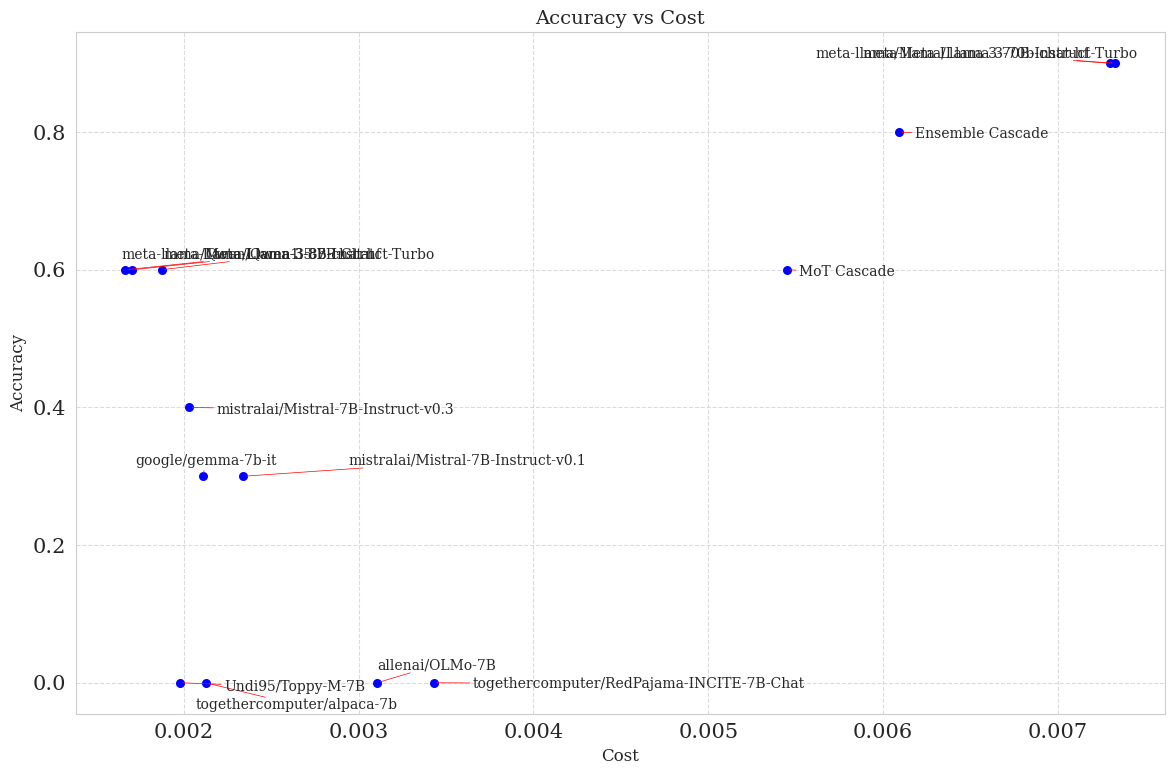

In [107]:
plt.figure(figsize=(12, 8))
scatter = plt.scatter(df_results['cost'], df_results['accuracy'], s=30, color='blue')

texts = []
for i, model in enumerate(df_results['model']):
    texts.append(plt.text(df_results['cost'][i], df_results['accuracy'][i], model, fontsize=10))

plt.title('Accuracy vs Cost', fontsize=14)
plt.xlabel('Cost', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)

plt.grid(True, linestyle='--', alpha=0.7)

# Adjust the text labels to minimize overlap
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='red', lw=0.5))

plt.tight_layout()
plt.show()